In [58]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

tf.get_logger().setLevel(logging.ERROR)


class Gan():

    def __init__(self, data):
        self.data = data
        self.n_epochs = 200

    # Genereta random noise in a latent space
    def _noise(self):

        #prng = np.random.RandomState(seed = None)
        #noise = prng.normal(0, 1, self.data.shape)
        random.seed(0)
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        
        for epoch in range(self.n_epochs):
            
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        return generator

In [54]:
data =pd.read_csv("C:/Users/HP/Desktop/dati sintetici/Escherichia_coli_Meropenem.csv", sep = '\t')


def _df(data):
    df = pd.DataFrame(data)
    for c in range(df.shape[1]):
        mapping = {df.columns[c]: c}
        df = df.rename(columns=mapping)
    return df


X = data.drop('ID', axis=1)
X = (X.drop(columns=["Meropenem"])).values


#data = _df(StandardScaler().fit_transform(X))
data=_df(X)


In [56]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.0004,0.0005,0.0004,0.0004,0.0002,0.0002,0.0000,0.0001,0.0006,0.0005,...,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0007,0.0004,0.0002,0.0003,0.0002,0.0002,0.0002,0.0001,0.0008,0.0015,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0017,0.0018,0.0014,0.0017,0.0014,0.0009,0.0007,0.0006,0.0006,0.0007,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0003,0.0002,0.0003,0.0005,0.0004,0.0004,0.0006,0.0003,0.0001,0.0001,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0001,0.0002,0.0002,0.0002,0.0002,0.0003,0.0003,0.0003,0.0003,0.0003,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [59]:
model = Gan(data=data)
#model.summary()
generator = model._generator()
descriminator = model._discriminator()
gan_model = model._GAN(generator=generator, discriminator=descriminator)
trained_model = model.train(
    generator=generator, discriminator=descriminator, gan=gan_model)

7/7 [==============================] - 0s 6ms/step
>1, d1=0.694, d2=0.793
7/7 [==============================] - 0s 9ms/step
>2, d1=0.700, d2=0.726
7/7 [==============================] - 0s 7ms/step
>3, d1=0.699, d2=0.700
7/7 [==============================] - 0s 6ms/step
>4, d1=0.698, d2=0.691
7/7 [==============================] - 0s 6ms/step
>5, d1=0.699, d2=0.688
7/7 [==============================] - 0s 8ms/step
>6, d1=0.700, d2=0.690
7/7 [==============================] - 0s 6ms/step
>7, d1=0.697, d2=0.692
7/7 [==============================] - 0s 10ms/step
>8, d1=0.695, d2=0.694
7/7 [==============================] - 0s 6ms/step
>9, d1=0.693, d2=0.698
7/7 [==============================] - 0s 6ms/step
>10, d1=0.691, d2=0.700
7/7 [==============================] - 0s 5ms/step
>11, d1=0.689, d2=0.703
7/7 [==============================] - 0s 6ms/step
>12, d1=0.687, d2=0.706
7/7 [==============================] - 0s 5ms/step
>13, d1=0.685, d2=0.708
7/7 [============================

In [62]:
random.seed(0)
noise = np.random.normal(0, 1, data.shape) 
new_data = _df(data=trained_model.predict(noise))

7/7 [==============================] - 0s 5ms/step


In [63]:
new_data.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,-0.0076,-0.0512,-0.0008,0.0142,-0.0022,0.0296,0.0537,0.0498,-0.0307,-0.0231,...,0.0556,0.0150,-0.0574,0.0612,0.0356,0.0479,0.0199,-0.0588,0.0051,0.0231
1,-0.0076,-0.0512,-0.0008,0.0142,-0.0022,0.0296,0.0537,0.0498,-0.0307,-0.0231,...,0.0556,0.0150,-0.0574,0.0612,0.0356,0.0479,0.0199,-0.0588,0.0051,0.0231
2,-0.0076,-0.0512,-0.0008,0.0142,-0.0022,0.0296,0.0537,0.0498,-0.0307,-0.0231,...,0.0556,0.0150,-0.0574,0.0612,0.0356,0.0479,0.0199,-0.0588,0.0051,0.0231
3,-0.0076,-0.0512,-0.0008,0.0142,-0.0022,0.0296,0.0537,0.0498,-0.0307,-0.0231,...,0.0556,0.0150,-0.0574,0.0612,0.0356,0.0479,0.0199,-0.0588,0.0051,0.0231
4,-0.0068,-0.0511,-0.0001,0.0156,-0.0021,0.0298,0.0543,0.0498,-0.0302,-0.0214,...,0.0569,0.0154,-0.0580,0.0597,0.0352,0.0487,0.0190,-0.0588,0.0040,0.0228


Evaluation 

Text(0.5, 1.0, 'synthetic Data')

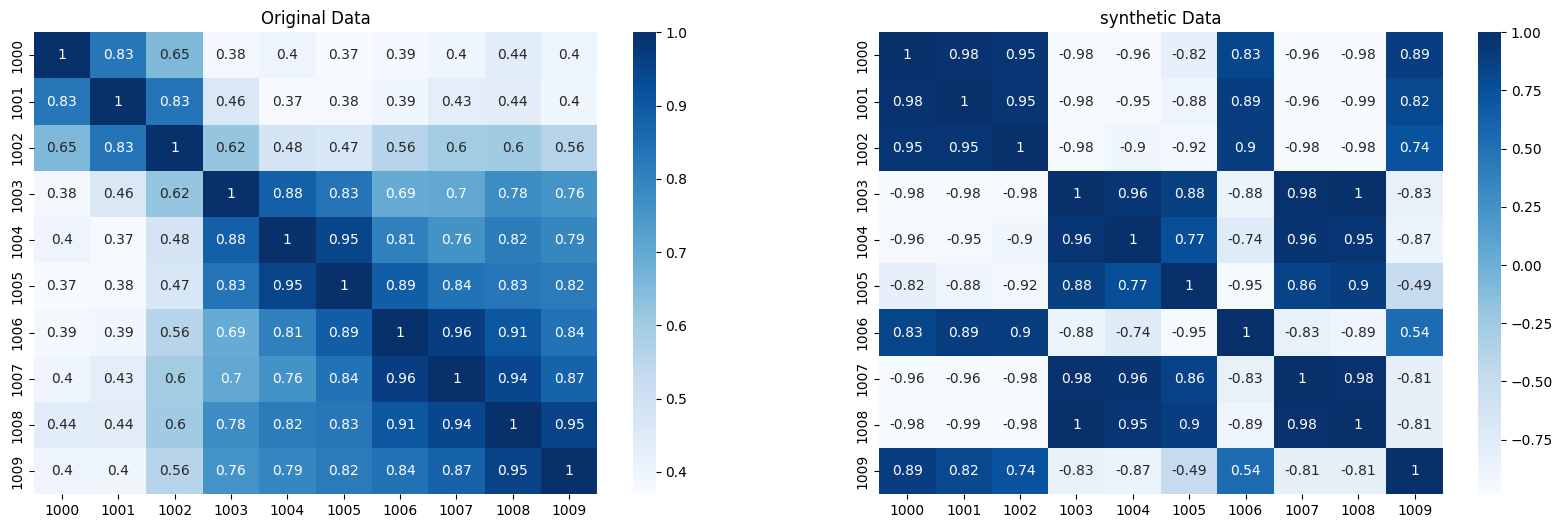

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(data10.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(new_data10.corr(), annot=True, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

In [36]:
import sdmetrics 
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports.single_table import QualityReport
#create the metadata object
metadata = SingleTableMetadata()

metadata.detect_from_dataframe(data= data)
metadata_dict = metadata.to_dict()
#metadata.validate()


#Quality report 


report = QualityReport()
report.generate(data, new_data, metadata_dict)

Creating report:   0%|          | 0/4 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [65]:
#Evaluate just 10 columns
import sdmetrics 
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports.single_table import QualityReport


data10= data.iloc[:, 1000:1010]
new_data10=new_data.iloc[:, 1000:1010]

#create the metadata object

metadata = SingleTableMetadata()

metadata.detect_from_dataframe(data= data10)
metadata_dict = metadata.to_dict()
#metadata.validate()


#Quality report 

report = QualityReport()
report.generate(data10, new_data10, metadata_dict)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Overall Quality Score: 36.13%

Properties:
Column Shapes: 0.49%
Column Pair Trends: 71.78%


In [66]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,1000,KSComplement,0.0000
1,1001,KSComplement,0.0341
2,1002,KSComplement,0.0000
3,1003,KSComplement,0.0098
4,1004,KSComplement,0.0000
5,1005,KSComplement,0.0049
6,1006,KSComplement,0.0000
7,1007,KSComplement,0.0000
8,1008,KSComplement,0.0000
9,1009,KSComplement,0.0000


In [67]:
from sdmetrics.reports.single_table import DiagnosticReport

report = DiagnosticReport()
report.generate(data10, new_data10, metadata_dict)
report.get_properties()

Creating report:   0%|          | 0/4 [00:00<?, ?it/s]Unexpected error occured when calculating NewRowSynthesis metric:
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sdmetrics\reports\single_table\diagnostic_report.py", line 99, in generate
    self._metric_results[metric_name] = metric.compute_breakdown(
  File "c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sdmetrics\single_table\new_row_synthesis.py", line 90, in compute_breakdown
    new_column_name = strip_characters(['\n', '.', "'"], column_name)
  File "c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sdmetrics\utils.py", line 295, in strip_characters
    if character in result:
TypeError: argument of type 'int' is not iterable
Creating report: 100%|██████████| 4/4 [00:00<00:00, 90.24it/s]


DiagnosticResults:

DANGER:
x The synthetic data is missing more than 50% of the numerical ranges present in the real data
x More than 50% the synthetic data does not follow the min/max boundaries set by the real data


{'Coverage': 0.3, 'Synthesis': nan, 'Boundaries': 0.0}

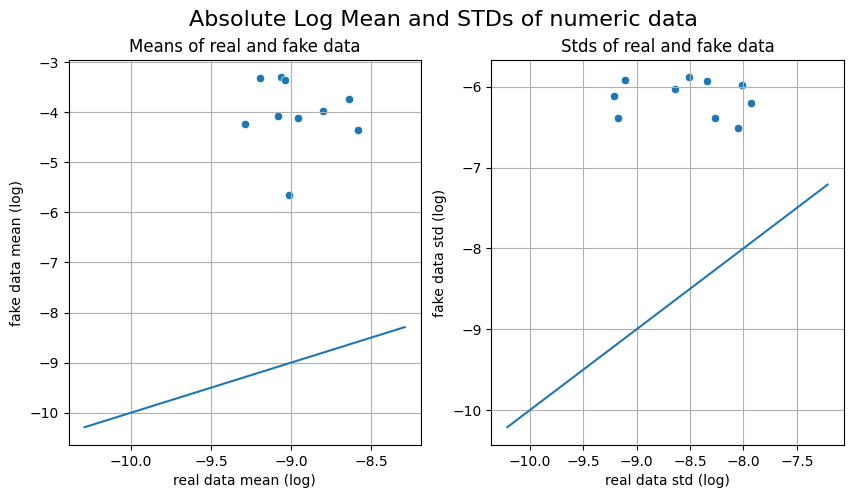

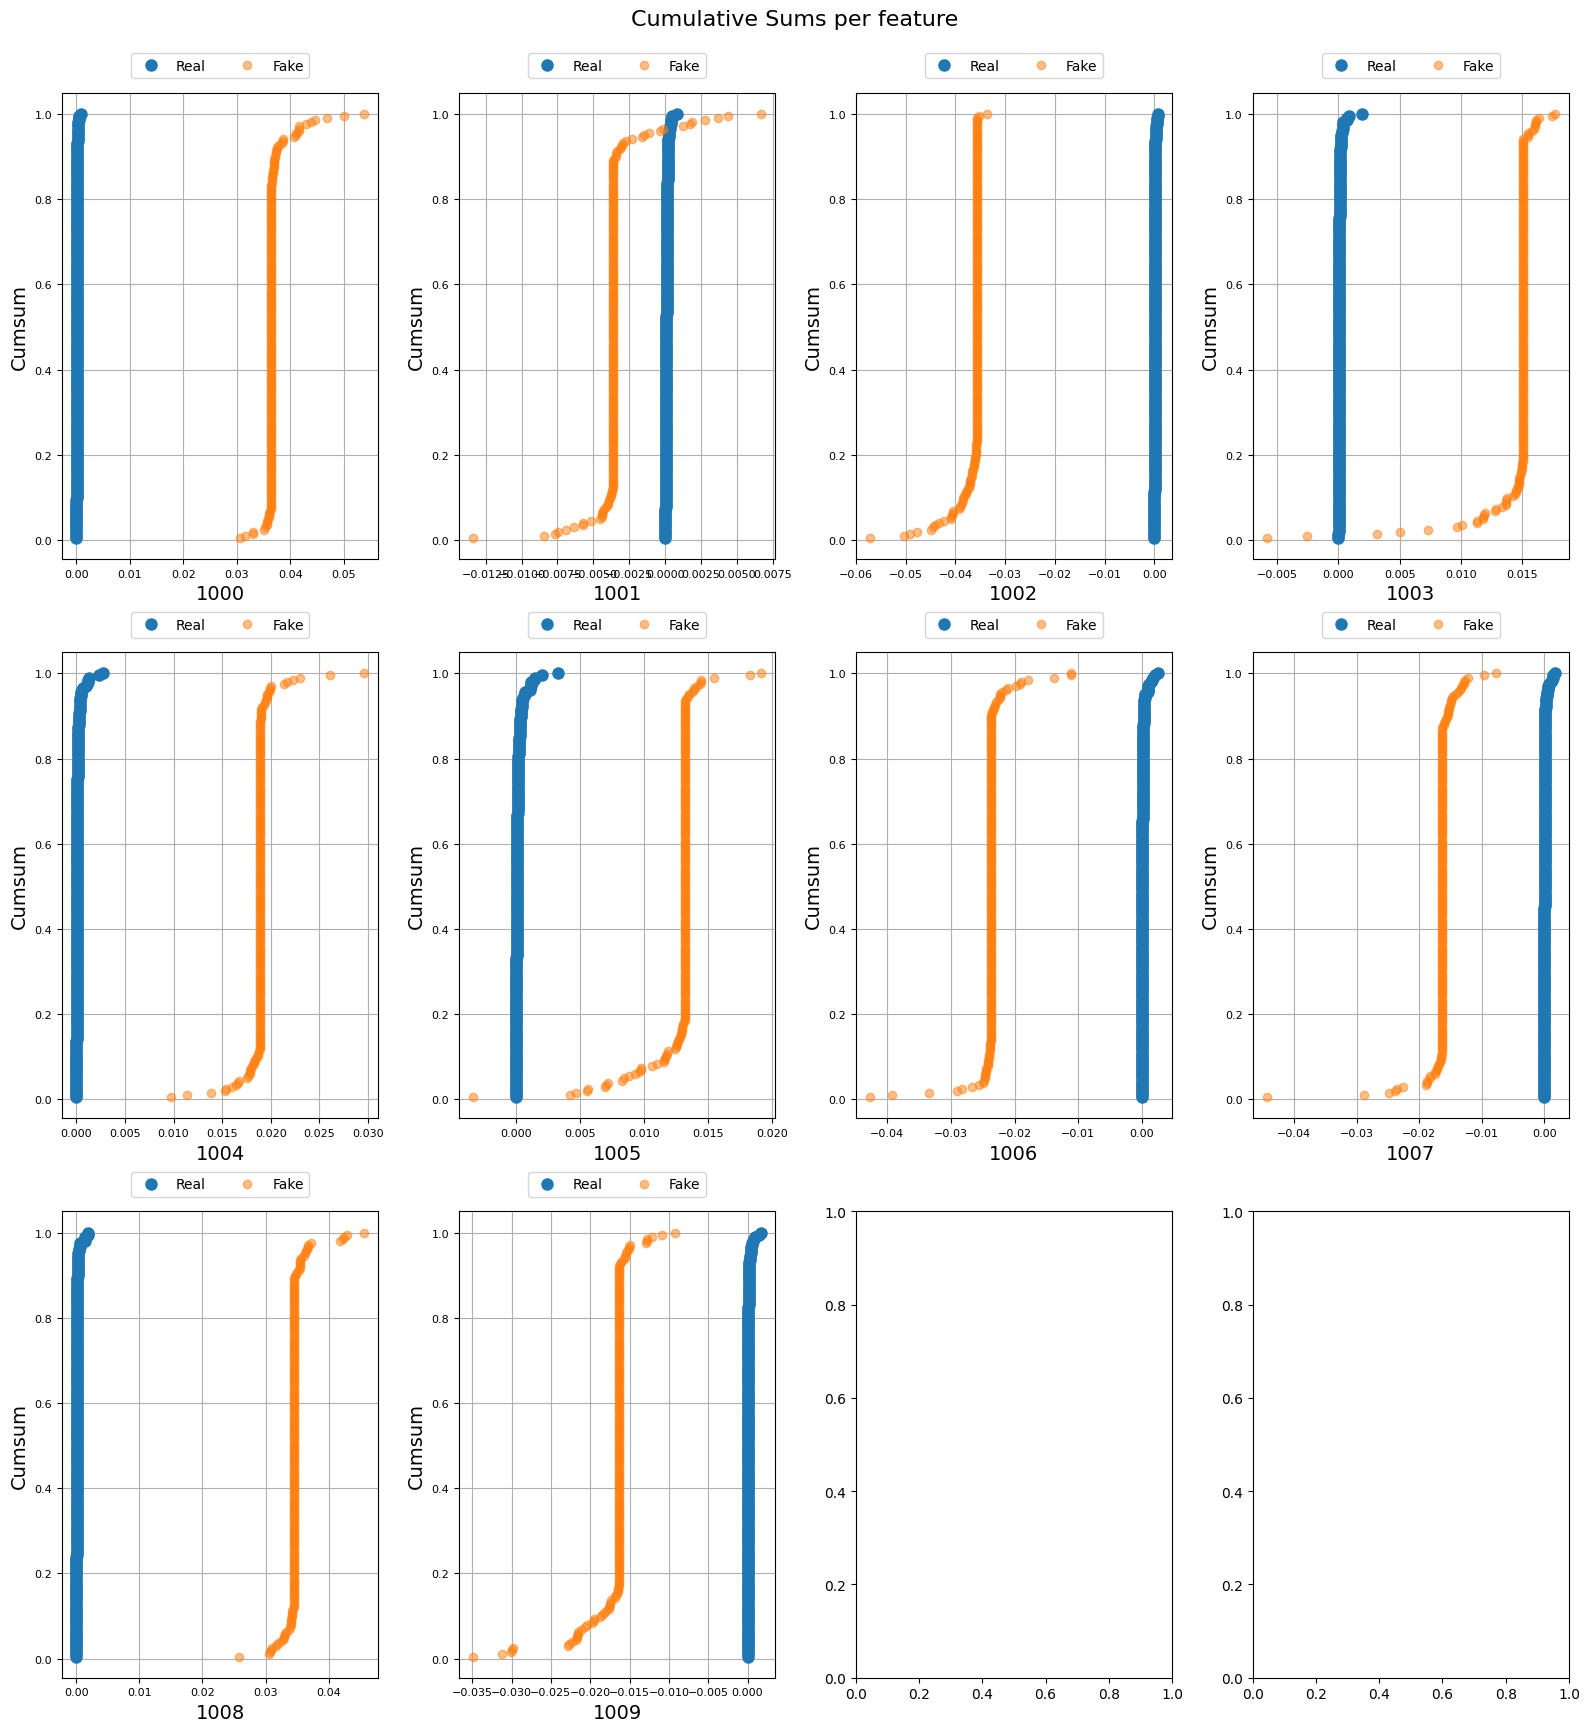

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p

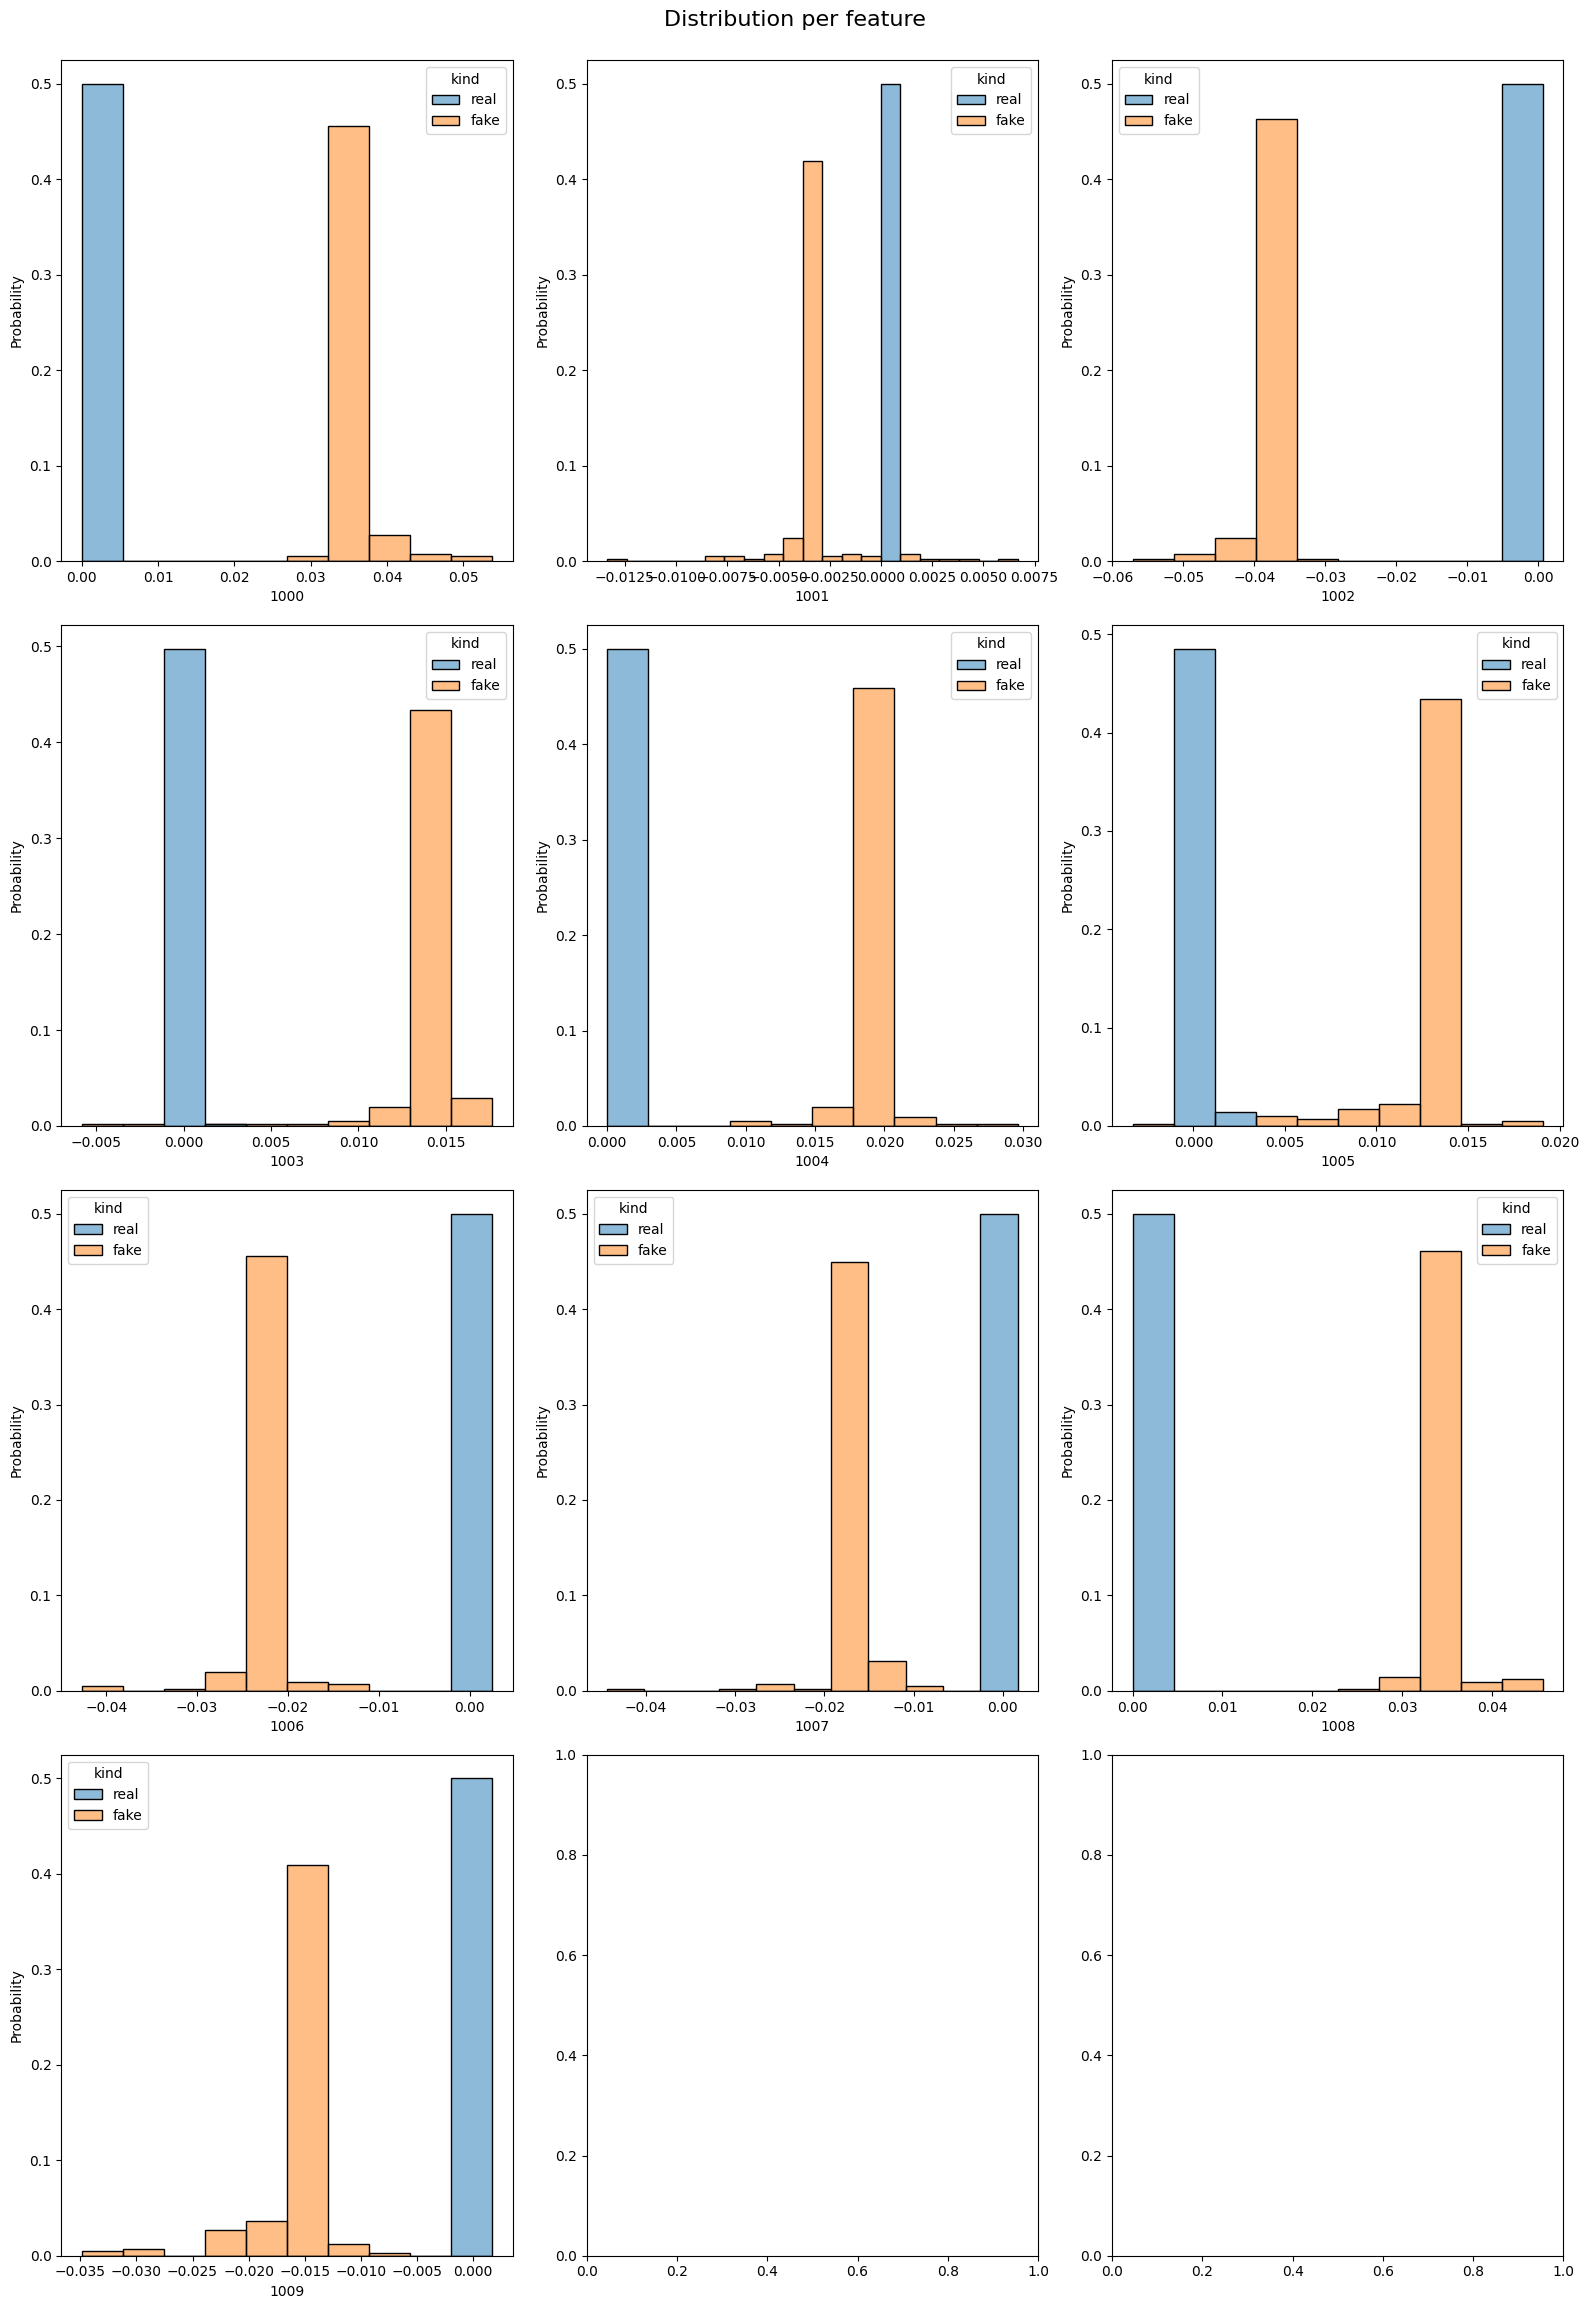

TypeError: Image data of dtype object cannot be converted to float

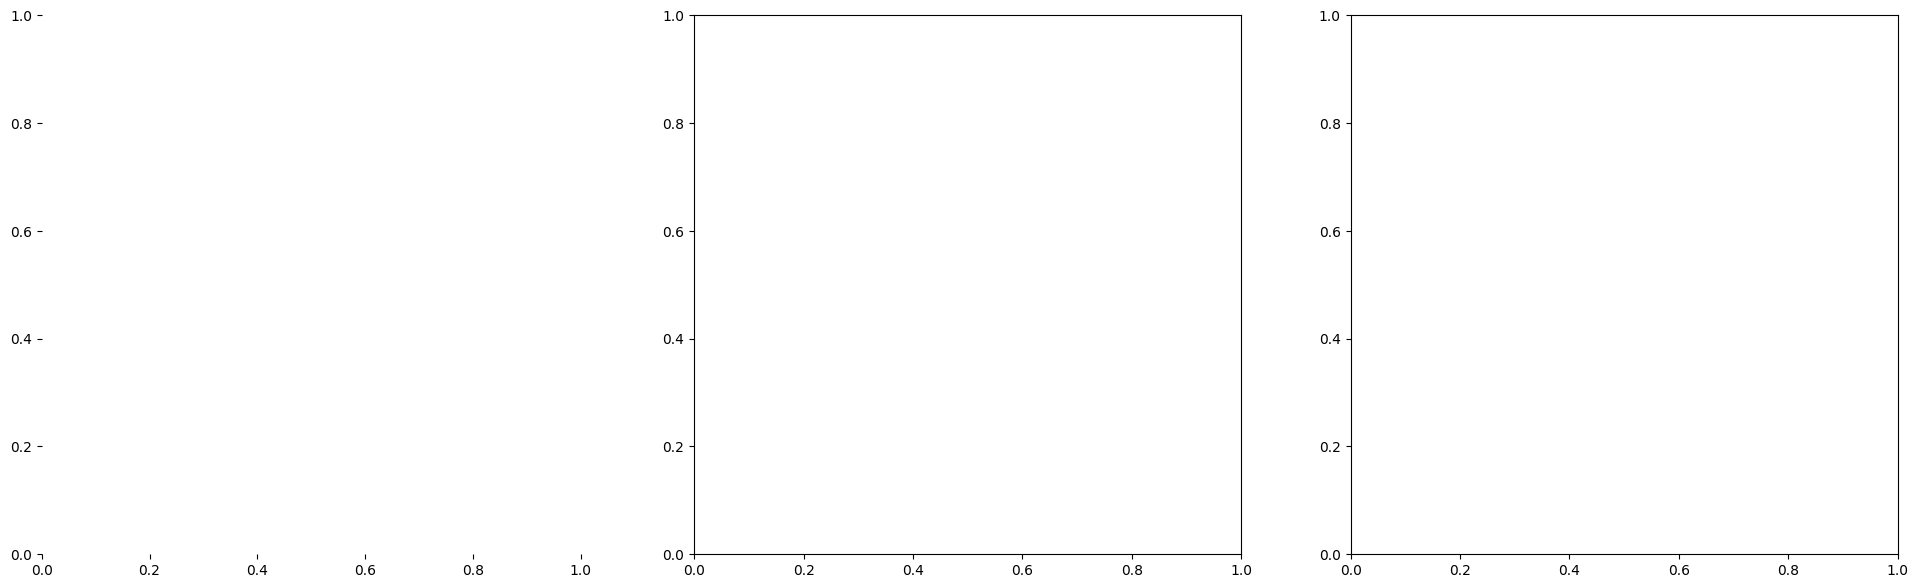

In [68]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data10, new_data10)
table_evaluator.visual_evaluation()